In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


import numpy as np
import pandas as pd
import cv2 as cv

from matplotlib.image import imread
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join


In [3]:
batch_size = 32   # tamaño de los conjuntos de entrenamiento que se le pasan al modelo para que no aprenda todo de golpe y no se bloquee.
img_height = 48
img_width = 48

data_dir = os.getcwd() + os.sep + 'feeling' + os.sep + 'train'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(train_ds.class_names)

# Generación del conjunto de X_test
df_dict = []
data_path = os.getcwd() + os.sep + 'feeling' + os.sep + 'test'
only_image_names = [f for f in listdir(data_path) if isfile(join(data_path, f))]
for image_name in only_image_names:
    if ".jpg" in image_name:      
        image_fullpath = data_path + os.sep + image_name
        image_cv = cv.imread(image_fullpath)     # con el 0 se lee en blanco y negro, sin nada, se lee en color

        # las imagenes originales tienen tamañanos distintos  -> con esta función se ponen en el tamaño común para todas (y será el tamaño de entrada al modelo)
        image_cv = cv.resize(image_cv, (img_height, img_width)) 
        df_dict.append({'image':image_cv})

df = pd.DataFrame(df_dict)
X_test = np.stack(np.array(df["image"]))

Found 6176 files belonging to 2 classes.
Using 4941 files for training.
Found 6176 files belonging to 2 classes.
Using 1235 files for validation.
['happy', 'sadness']


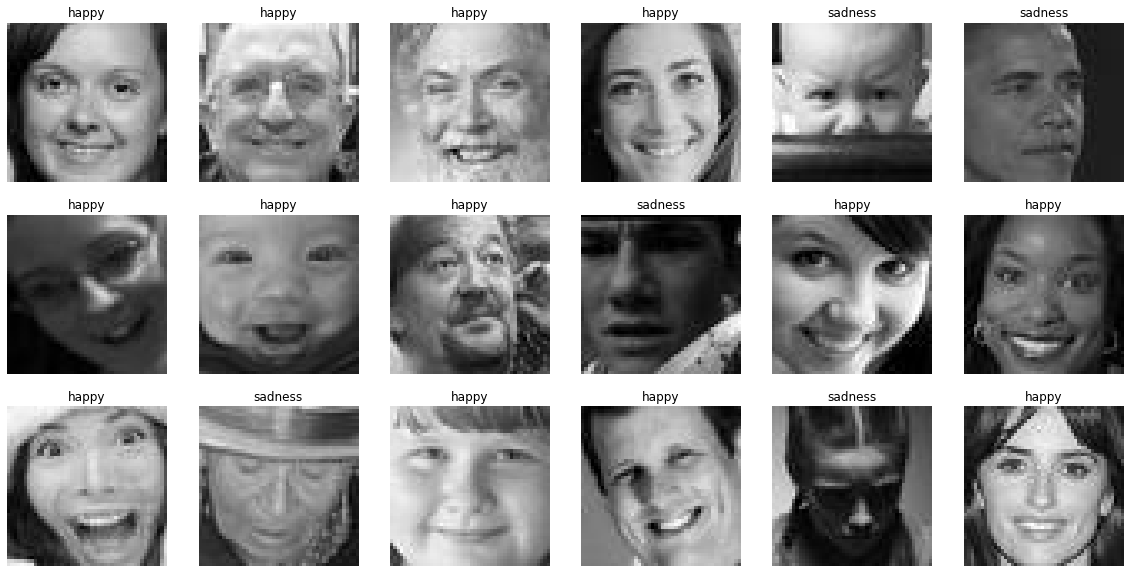

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 48, 48, 3)
(32,)


In [6]:
X_test.shape

(4117, 48, 48, 3)

## VGG16

### Ejemplo de como entrenar una red a partir de una red existente (transfer learning)
En este caso vamos a importar la red VGG16, que utilizaremos como red preentrenada y completaremos con una fully connected layer. 

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import datasets, layers, models

base_model = VGG16(input_shape = (img_height, img_width, 3),
                  include_top=False,        # permite entrenar el modelo con una resolución distinta a la original (en este caso 48x48)
                  weights = 'imagenet')

# no se entrenan las capas previamente entrenadas
for layer in base_model.layers:
    layer.trainable = False

    
##### FULLY CONNECTED LAYER #####
x0 = layers.Flatten()(base_model.output)    # Flatten the output layer to 1 dimension
x1 = layers.Dense(512, activation='relu')(x0)   # Add a fully connected layer with 512 hidden units and ReLU activation
x2 = layers.Dropout(0.5)(x1)        # Add a dropout rate of 0.5
#x3 = layers.Dense(1, activation='sigmoid')(x2)  # Add a final sigmoid layer for classification

x3 = layers.Dense(2 , activation='softmax')(x2)

# se concatena la primera capa (base_model.input) con la última capa (x3)
model = tf.keras.models.Model(base_model.input, x3)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
vgghist = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 10,
                    verbose=1)

Epoch 1/10
155/155 [==============================] - 32s 202ms/step - loss: 4.4704 - acc: 0.6205 - val_loss: 1.4549 - val_acc: 0.6510
Epoch 2/10
155/155 [==============================] - 35s 225ms/step - loss: 1.1705 - acc: 0.6905 - val_loss: 0.8394 - val_acc: 0.6729
Epoch 3/10
155/155 [==============================] - 34s 220ms/step - loss: 0.6536 - acc: 0.7276 - val_loss: 0.7160 - val_acc: 0.6988
Epoch 4/10
155/155 [==============================] - 34s 220ms/step - loss: 0.5261 - acc: 0.7571 - val_loss: 0.6799 - val_acc: 0.7028
Epoch 5/10
155/155 [==============================] - 34s 221ms/step - loss: 0.4524 - acc: 0.7913 - val_loss: 0.6839 - val_acc: 0.7045
Epoch 6/10
155/155 [==============================] - 36s 230ms/step - loss: 0.4192 - acc: 0.8112 - val_loss: 0.7002 - val_acc: 0.7045
Epoch 7/10
155/155 [==============================] - 36s 230ms/step - loss: 0.3852 - acc: 0.8255 - val_loss: 0.6873 - val_acc: 0.7085
Epoch 8/10
155/155 [==============================] - 3

In [73]:
%%time
predictions_vgg16 = model.predict(X_test)

Wall time: 21.1 s


In [70]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import datasets, layers, models

base_model_vgg19 = VGG19(input_shape = (img_height, img_width, 3),
                  include_top=False,        # permite entrenar el modelo con una resolución distinta a la original (en este caso 48x48)
                  weights = 'imagenet')

# no se entrenan las capas previamente entrenadas
for layer in base_model_vgg19.layers:
    layer.trainable = False

    
##### FULLY CONNECTED LAYER #####
x0 = layers.Flatten()(base_model_vgg19.output)    # Flatten the output layer to 1 dimension
x1 = layers.Dense(512, activation='relu')(x0)   # Add a fully connected layer with 512 hidden units and ReLU activation
x2 = layers.Dropout(0.5)(x1)        # Add a dropout rate of 0.5
#x3 = layers.Dense(1, activation='sigmoid')(x2)  # Add a final sigmoid layer for classification

x3 = layers.Dense(2 , activation='softmax')(x2)

# se concatena la primera capa (base_model.input) con la última capa (x3)
model_vgg19 = tf.keras.models.Model(base_model_vgg19.input, x3)

model_vgg19.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
vgghist = model_vgg19.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 10,
                    verbose=1)

80142336/80134624 [==============================] - 7s 0us/step
Epoch 1/10
155/155 [==============================] - 40s 258ms/step - loss: 5.0032 - acc: 0.6102 - val_loss: 1.5031 - val_acc: 0.6745
Epoch 2/10
155/155 [==============================] - 43s 279ms/step - loss: 1.2804 - acc: 0.6788 - val_loss: 0.8825 - val_acc: 0.6632
Epoch 3/10
155/155 [==============================] - 43s 280ms/step - loss: 0.6678 - acc: 0.7199 - val_loss: 0.7785 - val_acc: 0.6761
Epoch 4/10
155/155 [==============================] - 44s 282ms/step - loss: 0.5373 - acc: 0.7590 - val_loss: 0.7369 - val_acc: 0.6842
Epoch 5/10
155/155 [==============================] - 42s 274ms/step - loss: 0.4653 - acc: 0.7853 - val_loss: 0.7754 - val_acc: 0.6737
Epoch 6/10
155/155 [==============================] - 42s 274ms/step - loss: 0.4445 - acc: 0.7911 - val_loss: 0.7692 - val_acc: 0.6915
Epoch 7/10
155/155 [==============================] - 44s 282ms/step - loss: 0.3934 - acc: 0.8229 - val_loss: 0.7931 - val_ac

In [71]:
%%time
predictions_vgg19 = model_vgg19.predict(X_test)

Wall time: 28.1 s


## ResNet50V2

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

# librería de apoyo para utilizar redes preentrenadas
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

# con esta instrucción se está descargando el model_ResNet50V2o completo original
base_model_ResNet50V2 = ResNet50V2(input_shape=(img_height, img_width, 3),      #permite ajustar los parámetros de las imágenes que se inserten en la red neuronal
                       include_top=False,
                       weights = "imagenet",
                       classifier_activation='softmax')

#base_model_ResNet50V2.summary() 

# no se entrenan las capas previamente entrenadas
for layer in base_model_ResNet50V2.layers:
    layer.trainable = False

    
##### FULLY CONNECTED LAYER #####
x0 = layers.Flatten()(base_model_ResNet50V2.output)  # Flatten the output layer to 1 dimension
x1 = layers.Dense(2 , activation='softmax')(x0)     # se añade una capa binaria para ajustarse a las posibilidades de la salida

# se concatena la primera capa (base_model_ResNet50V2.input) con la última capa (x3)
model_ResNet50V2 = tf.keras.models.Model(base_model_ResNet50V2.input, x1)

model_ResNet50V2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
RR50v2hist = model_ResNet50V2.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 10,
                    verbose=1)



Epoch 1/10
155/155 [==============================] - 18s 107ms/step - loss: 27.9437 - acc: 0.5707 - val_loss: 36.8744 - val_acc: 0.5126
Epoch 2/10
155/155 [==============================] - 17s 110ms/step - loss: 26.6618 - acc: 0.6043 - val_loss: 13.2498 - val_acc: 0.6429
Epoch 3/10
155/155 [==============================] - 19s 120ms/step - loss: 16.3530 - acc: 0.6400 - val_loss: 45.3928 - val_acc: 0.5231
Epoch 4/10
155/155 [==============================] - 20s 127ms/step - loss: 24.0539 - acc: 0.6323 - val_loss: 34.7435 - val_acc: 0.5806
Epoch 5/10
155/155 [==============================] - 20s 129ms/step - loss: 21.2220 - acc: 0.6547 - val_loss: 22.4273 - val_acc: 0.6300
Epoch 6/10
155/155 [==============================] - 18s 117ms/step - loss: 14.5113 - acc: 0.6841 - val_loss: 37.2159 - val_acc: 0.5757
Epoch 7/10
155/155 [==============================] - 18s 116ms/step - loss: 15.4397 - acc: 0.6928 - val_loss: 45.8598 - val_acc: 0.5595
Epoch 8/10
155/155 [=====================

In [56]:
%%time
predictions_RR50v2 = model_ResNet50V2.predict(X_test)

Wall time: 13.1 s


## Resnet v2

https://keras.io/api/applications/resnet/

In [67]:

from tensorflow.keras.applications.resnet_v2 import ResNet152V2

base_model_resnet = ResNet152V2(input_shape = (img_height, img_width,3),
                        include_top = False,
                        weights = 'imagenet')

for layer in base_model_resnet.layers:
    layer.trainable = False

# Se añaden dios capas adicionales para una predicción binaria
x0 = layers.Flatten()(base_model_resnet.output)
x1 = layers.Dense(32, activation='relu')(x0)   
x2 = layers.Dropout(0.5)(x1) 
x3 = layers.Dense(2 , activation='softmax')(x2)

model_resnet = tf.keras.models.Model(base_model_resnet.input, x3)

model_resnet.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

RN152_history = model_resnet.fit(train_ds,
                       validation_data = val_ds,
                       epochs = 10,
                       verbose=1)  


Epoch 1/10
155/155 [==============================] - 54s 322ms/step - loss: 20.1242 - acc: 0.5305 - val_loss: 0.6924 - val_acc: 0.5198
Epoch 2/10
155/155 [==============================] - 50s 324ms/step - loss: 0.6912 - acc: 0.5349 - val_loss: 0.6924 - val_acc: 0.5198
Epoch 3/10
155/155 [==============================] - 49s 315ms/step - loss: 0.6909 - acc: 0.5349 - val_loss: 0.6926 - val_acc: 0.5198
Epoch 4/10
155/155 [==============================] - 50s 322ms/step - loss: 0.6908 - acc: 0.5349 - val_loss: 0.6926 - val_acc: 0.5198
Epoch 5/10
155/155 [==============================] - 52s 335ms/step - loss: 0.6908 - acc: 0.5349 - val_loss: 0.6927 - val_acc: 0.5198
Epoch 6/10
155/155 [==============================] - 49s 314ms/step - loss: 0.6908 - acc: 0.5349 - val_loss: 0.6927 - val_acc: 0.5198
Epoch 7/10
155/155 [==============================] - 49s 314ms/step - loss: 0.6908 - acc: 0.5349 - val_loss: 0.6927 - val_acc: 0.5198
Epoch 8/10
155/155 [==============================] - 

In [35]:
%%time
predictions_RN152 = model_resnet.predict(X_test)

Wall time: 30.7 s


In [59]:
predictions_RN152[0]

array([1., 0.], dtype=float32)

In [52]:
predictions_RN152[0]

array([1., 0.], dtype=float32)

In [57]:
predictions_vgg16[0]

array([0.46933684, 0.5306632 ], dtype=float32)

In [58]:
predictions_RR50v2[0]

array([9.999925e-01, 7.537415e-06], dtype=float32)

# Submission

In [85]:
i = 12

opt

0

In [87]:
img_submission = []
data_path = os.getcwd() + os.sep + 'feeling' + os.sep + 'test'
only_image_names = [f for f in listdir(data_path) if isfile(join(data_path, f))]
for image_name in only_image_names:
    if ".jpg" in image_name:
        img_submission.append(image_name.replace('.jpg',''))

## Creacion del 'voting'
#predictions = predictions_vgg16   # obtiene un 0.72153 por sí misma
#predictions = predictions_vgg19   # obtiene un  0.71211 por sí misma
#predictions = predictions_RR50v2  # obtiene un 0.64439 por sí misma, ya merece la pena meterla en el 'voting' (la versión anterior sacaba un 0'54 aprox)
#predictions = predictions_RN152     # obtiene un 0.55572 por sí misma, no merece la pena meterla en el 'voting'
predictions = []
for i in range(len(predictions_vgg16)):
    opt_0 = (predictions_vgg16[i][0]+predictions_vgg19[i][0]+predictions_RR50v2[i][0])/3
    opt_1 = (predictions_vgg16[i][1]+predictions_vgg19[i][1]+predictions_RR50v2[i][1])/3
    predictions.append([opt_0, opt_1])

predictions_submit = []
for i in range(len(predictions)):
    predictions_submit.append(train_ds.class_names[np.argmax(predictions[i])])      

submission = pd.DataFrame({"id_img": img_submission, "label": predictions_submit})    
submission.to_csv("submission.csv", index = False) #muy importante el index = False

# Output DashBoard

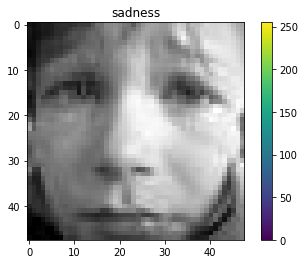

In [60]:
img_check = 0

plt.figure()
plt.imshow(X_test[img_check])
plt.colorbar()
plt.title(train_ds.class_names[np.argmax(predictions_vgg16[img_check])])
plt.grid(False)
plt.show()

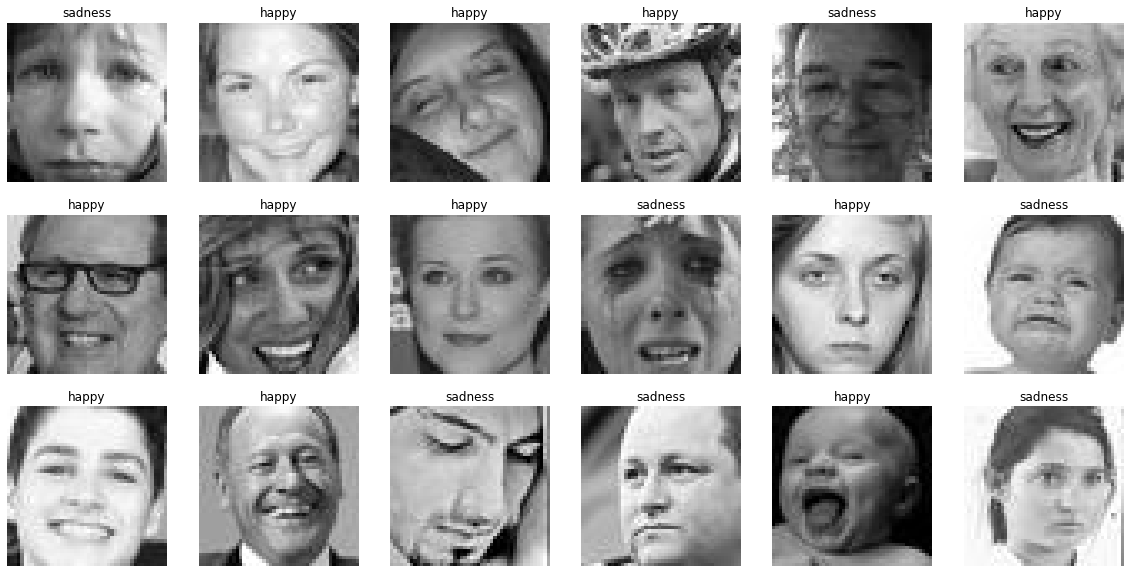

In [88]:
plt.figure(figsize=(20, 10))
for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(X_test[i])
    plt.title(train_ds.class_names[np.argmax(predictions[i])])
    plt.axis("off")

In [41]:
acum = 0
point_list = []
for i in range(predictions.shape[0]):
    if np.argmax(predictions[i]) == 1:
        acum += 1
        point_list.append(i)
acum

2017

### Inception - No se puede si no son 75x75 como mínimo

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (75, 75,3),
                        include_top = False,
                        weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 9s 0us/step


In [50]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])

inc_history = model.fit(train_ds,
                       validation_data = val_ds,
                       steps_per_epoch = 100,
                       epochs = 2)

Epoch 1/2


ValueError: in user code:

    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    Z:\Data_Science\Software\Python\Python_3.6.4\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:270 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 75, 75, 3), found shape=(None, 48, 48, 3)
